In [13]:
# Data science
import numpy as np
import pandas as pd

# PyTorch framework
import torch
import torchvision
from torch import cuda
from torchvision import datasets, transforms, models
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary

# Image tools
import matplotlib.pyplot as plt
from PIL import Image

# Others
import json
from timeit import default_timer as timer
import os, random


# notethat flowers102 dataset require scipy
# Define the data transformations for the dataset, so these will be applied to each image that are in the dataset
# Add random transforms in training set for better generalization
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# loading dataset directly from torchvision as suggested in our paper and we split the dataset into train, val, and test
train_dataset = torchvision.datasets.Flowers102(root='./data', split='train', transform=train_transforms, download=True)
val_dataset = torchvision.datasets.Flowers102(root='./data', split='val', transform=test_valid_transforms, download=True)
test_dataset = torchvision.datasets.Flowers102(root='./data', split='test', transform=test_valid_transforms, download=True)

# Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
validloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
# Amount of data in each split
print("Train dataset size: ", len(train_dataset))
print("Validation dataset size: ", len(val_dataset))
print("Test dataset size: ", len(test_dataset))
# create an empty dictionary to store the class counts


Train dataset size:  1020
Validation dataset size:  1020
Test dataset size:  6149


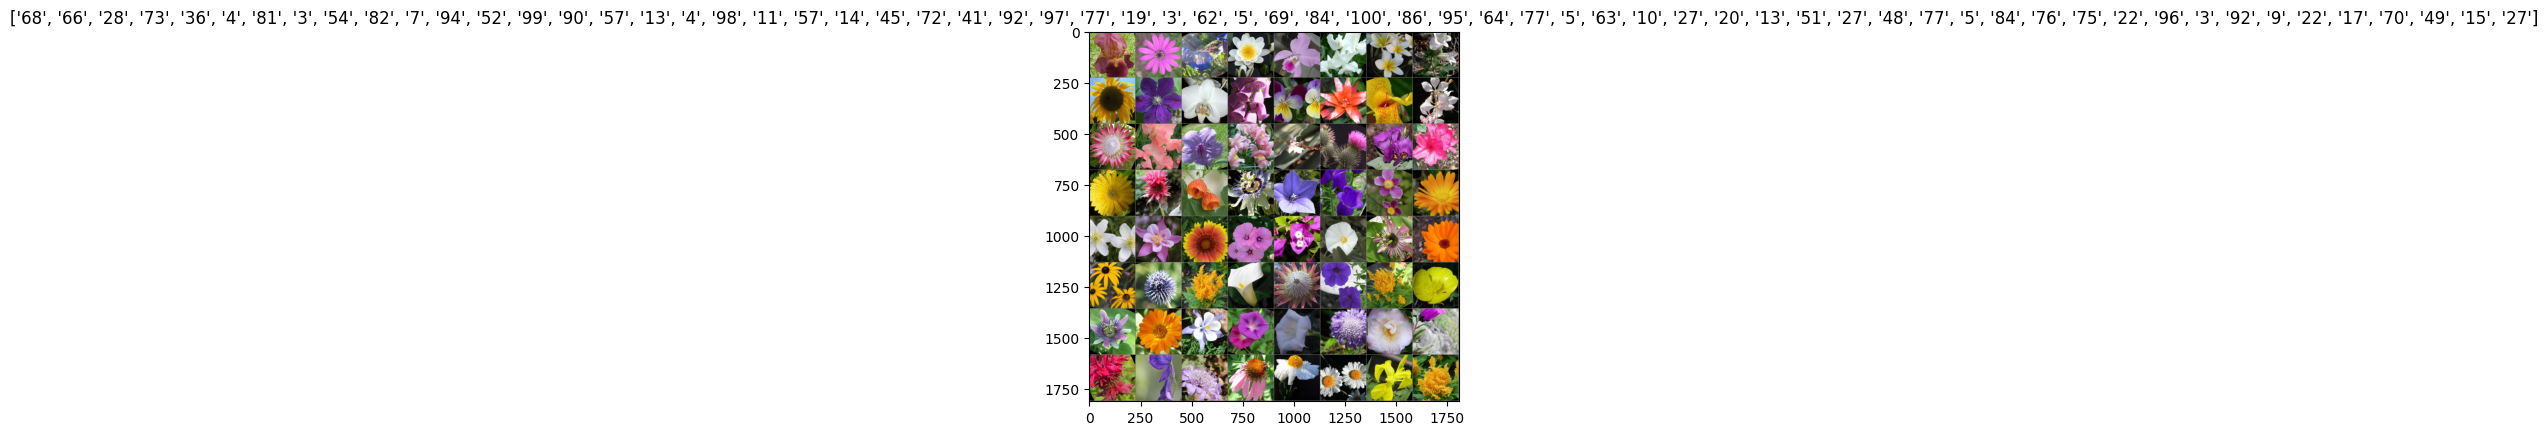

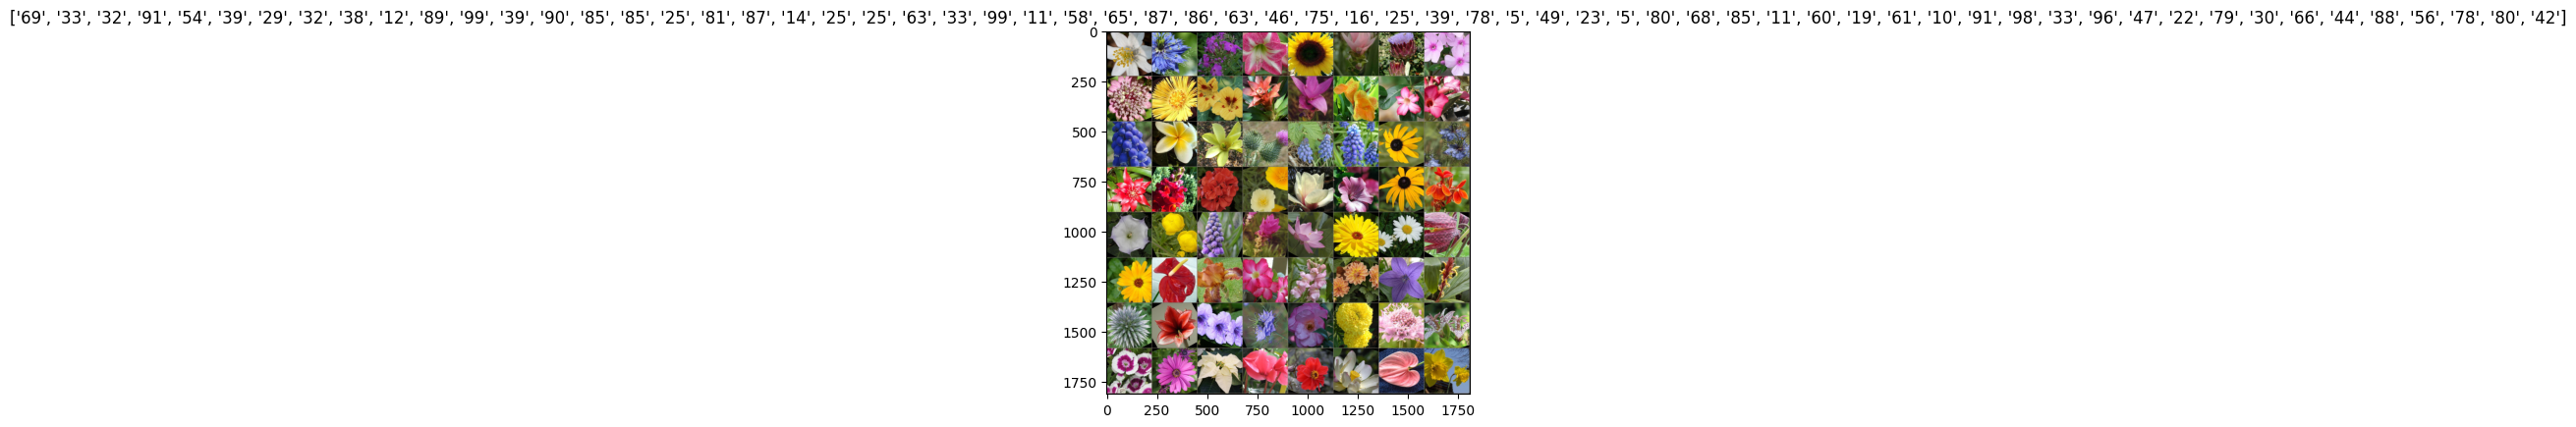

In [15]:
# Load the image labels and their corresponding names
import scipy.io
import os

labels_data = scipy.io.loadmat(os.path.join('./data', 'flowers-102', 'imagelabels.mat'))
labels = np.array(labels_data['labels'][0]) - 1  # Subtract 1 to make the labels zero-based




# Function to display images and their labels
# Function to display images and their labels
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of training data and their corresponding labels
inputs, classes = next(iter(trainloader))

# Make a grid from batch and display the images along with their labels
out = torchvision.utils.make_grid(inputs)
class_names = [str(int(x) + 1) for x in classes]  # Add 1 to make the labels one-based
imshow(out, title=class_names)



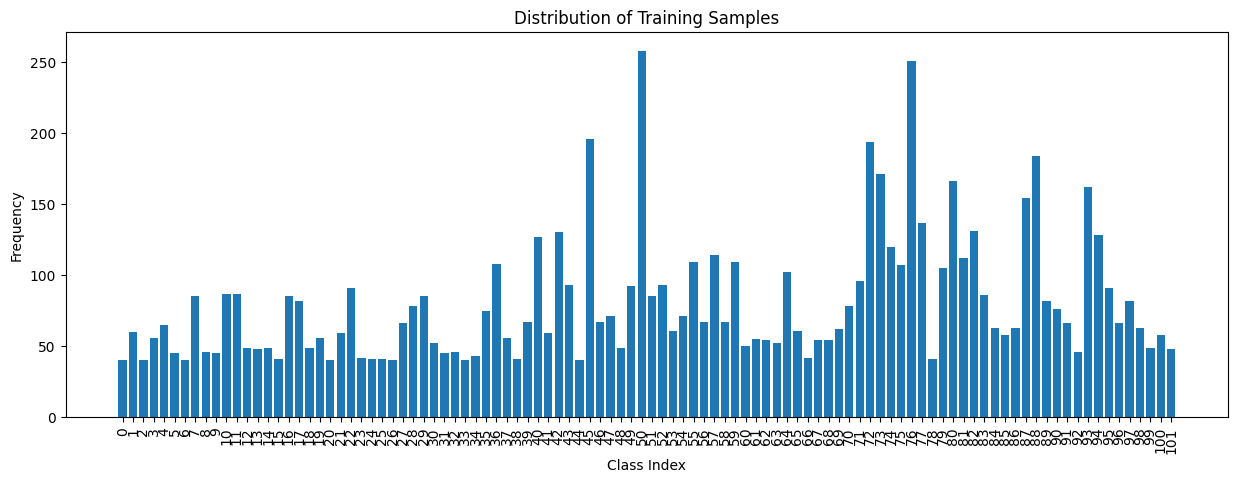

In [16]:
# Get distribution of training samples and show them using matplotlib
label_counts = np.bincount(labels)
class_indices = np.arange(len(label_counts))

plt.figure(figsize=(15, 5))
plt.bar(class_indices, label_counts)
plt.xlabel('Class Index')
plt.ylabel('Frequency')
plt.title('Distribution of Training Samples')
plt.xticks(class_indices, rotation='vertical')
plt.show()



Random training sample shape: (3, 224, 224)


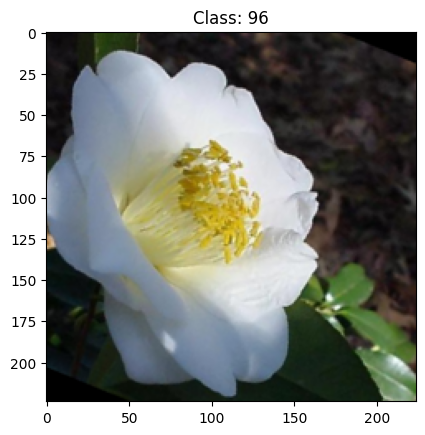

In [19]:
# Function to display a single image and its label
def display_image(image, label):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(f"Class: {label}")
    plt.show()

# Get a random image and its label from the trainloader
random_images, random_labels = next(iter(trainloader))
random_index = np.random.randint(0, len(random_images))
random_image = random_images[random_index]
random_label = random_labels[random_index].item()

# Display the random image and its shape
print(f"Random training sample shape: {np.array(random_image).shape}")
display_image(random_image, random_label + 1)  # Add 1 to make the label one-based


In [21]:

# Saving the upcoming model in a file
save_file_name = 'flower_classifier.pt'
checkpoint_path = 'flower_classifier.pth'

# Transforming the training dataset for better generalization
# Converting and transforming data to a normalized torch.FloatTensor
data_transforms_train = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=180),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.CenterCrop(size=224), # Imagenet standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # Imagenet standards

data_transforms_valid = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224), # Imagenet standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # Imagenet standards

data_transforms_test = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224), # Imagenet standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) # Imagenet standards


torch.Size([64, 3, 224, 224]) torch.Size([64])


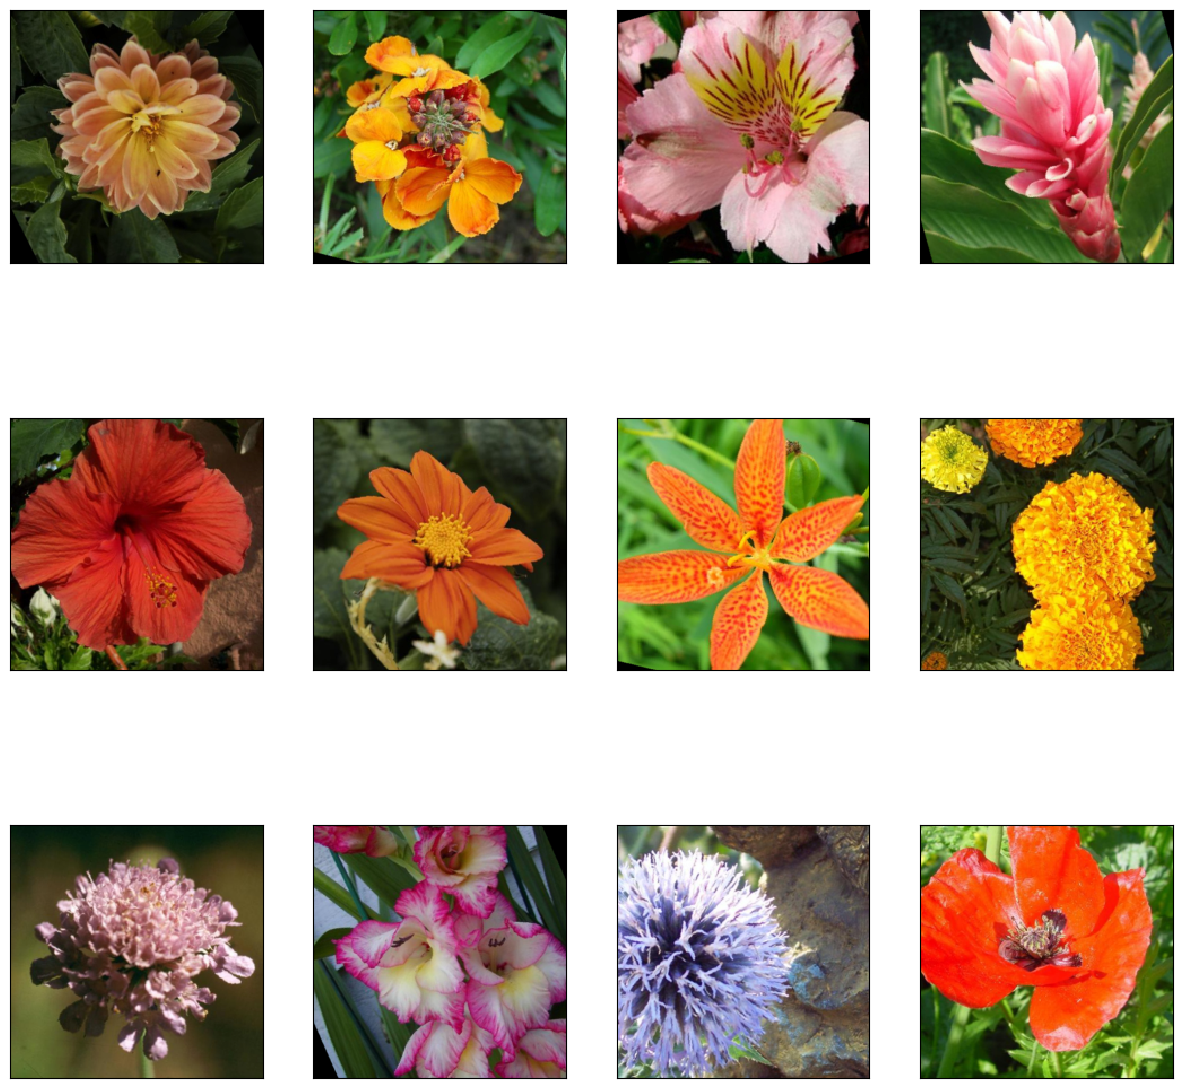

In [25]:
# Visualizing images from the trainloader
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

images, labels = next(iter(trainloader))
print(images.shape, labels.shape)
rows = 3
columns = 4
fig = plt.figure(figsize=(15, 15))

for i in range(12):
    fig.add_subplot(rows, columns, i + 1)
    img = images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, interpolation='nearest')

plt.show()



In [26]:

# Defining the model
model = models.densenet161(pretrained=True)

# Making sure the model's features parameters do not get updated as we train the classifier
for param in model.parameters():
    param.requires_grad = False

# Checking the model characteristics
print('\n', 'Model prior to modifications', '\n')
model


C:\Users\2012b\PycharmProjects\int2-assessment\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\2012b\PycharmProjects\int2-assessment\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\2012b/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:13<00:00, 8.37MB/s] 



 Model prior to modifications 



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [30]:
# Defining the model
model = models.densenet161(pretrained=True)

# Freezing the model's features parameters so they don't get updated as we train the classifier
for param in model.parameters():
    param.requires_grad = False

# Displaying the model characteristics before modifications
print('\n', 'Model prior to modifications', '\n')
print(model)




 Model prior to modifications 

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track

In [44]:
# Displaying the model's classifier before modifications
print('Model classifier before modifications')
print(model.classifier[0].in_features, '\n')



# Replacing the model's classifier with a custom one
n_inputs = 2208  # Getting the model's input size
model.classifier = nn.Sequential(
    nn.Linear(n_inputs, 1000),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(500, 102),
    nn.LogSoftmax(dim=1))

# Displaying the model's classifier after modifications
print('Model classifier after modifications', '\n')
print(model.classifier)



Model classifier before modifications
2208 

Model classifier after modifications 

Sequential(
  (0): Linear(in_features=2208, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=1000, out_features=500, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.4, inplace=False)
  (6): Linear(in_features=500, out_features=102, bias=True)
  (7): LogSoftmax(dim=1)
)


In [50]:
def train(model, train_loader, valid_loader, criterion, optimizer, save_file_name, max_epochs=5, num_epochs=50, print_every=2):
    epochs_no_improve = 0
    overall_start = timer()
    valid_loss_min = np.Inf
    valic_acc_max = 0
    hist = []
    train_on_gpu = torch.cuda.is_available()

    for epoch in range(num_epochs):

        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        model.train()
        start = timer()

        for ii, (data, target) in enumerate(train_loader):
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

        with torch.no_grad():
            model.eval()

            for data, target in valid_loader:
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item() * data.size(0)

                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() * data.size(0)

            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)

            hist.append([train_loss, valid_loss, train_acc, valid_acc])

            if (epoch + 1) % print_every == 0:
                print(
                    f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                )
                print(
                    f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                )

            if valid_loss < valid_loss_min:
                torch.save(model.state_dict(), save_file_name)
                print('Validation loss decreased -> Saving model')

                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            else:
                epochs_no_improve += 1
                if epochs_no_improve >= max_epochs:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    model.load_state_dict(torch.load(save_file_name))
                    model.optimizer = optimizer

                    hist = pd.DataFrame(
                        hist,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    return model, hist



In [ ]:
model, hist = train(
    model,
    train_loader = trainloader,
    valid_loader = validloader,
    criterion = nn.NLLLoss(),
    optimizer = optim.Adam(model.classifier.parameters(), lr= 0.001),
    save_file_name = 'flower_classifier.pt',
    max_epochs = 5,
    num_epochs = 50,
    print_every = 1)



Epoch: 0 	Training Loss: 4.6544 	Validation Loss: 4.5505
		Training Accuracy: 1.18%	 Validation Accuracy: 7.24%
Validation loss decreased -> Saving model

Epoch: 1 	Training Loss: 4.4940 	Validation Loss: 4.3088
		Training Accuracy: 5.10%	 Validation Accuracy: 24.28%
Validation loss decreased -> Saving model

Epoch: 2 	Training Loss: 4.1087 	Validation Loss: 3.7117
		Training Accuracy: 11.86%	 Validation Accuracy: 35.68%
Validation loss decreased -> Saving model

Epoch: 3 	Training Loss: 3.4188 	Validation Loss: 3.0077
		Training Accuracy: 23.14%	 Validation Accuracy: 39.39%
Validation loss decreased -> Saving model

Epoch: 4 	Training Loss: 2.6689 	Validation Loss: 2.1977
		Training Accuracy: 34.80%	 Validation Accuracy: 56.29%
Validation loss decreased -> Saving model

Epoch: 5 	Training Loss: 2.0931 	Validation Loss: 1.7981
		Training Accuracy: 45.10%	 Validation Accuracy: 62.47%
Validation loss decreased -> Saving model

Epoch: 6 	Training Loss: 1.6940 	Validation Loss: 1.5181
		T